<font color = 'Orange' size = 6> Satellite Dataset-RSI-CB256 trained with RESNET18 Architecture</font>

#### Importing Libraries

In [9]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.utils.data as td
import torchvision.datasets as datasets
from torchvision import models
from sklearn.model_selection import KFold
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import time
import os, random

from distutils.version import LooseVersion as Version
from itertools import product

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### EDA (Exploratory Data Analysis) and Preprocessing

In [11]:
root_dir = r'/content/drive/MyDrive/AI Project/Datasets/Satellite Dataset-RSI-CB256/data'

In [12]:
def count_target_classes(root_dir):
    '''return count of number of images per class'''
    target_classes = {}
    for folder in sorted(os.listdir(root_dir)):
        data_path_for_image_folder = root_dir+ '/'+str(folder) + '/'
        target_classes[str(folder)] = len([image_filename for image_filename in sorted(os.listdir(data_path_for_image_folder))])
    return target_classes

In [13]:
dict_class_count = count_target_classes(root_dir)

In [14]:
print("Total number of images for the datasets are :",sum(dict_class_count.values()))

Total number of images for the datasets are : 5631


In [7]:
def plot_hist(dict_target_count):
    plt.style.use('seaborn-darkgrid')
    plt.figure(figsize=(8,6))
    plt.bar(dict_target_count.keys(), dict_target_count.values(), 
            color= ['aqua', 'gold', 'green', 'blue'], edgecolor='k')
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.title("Number of images per class")
    plt.show()
    plt.close()

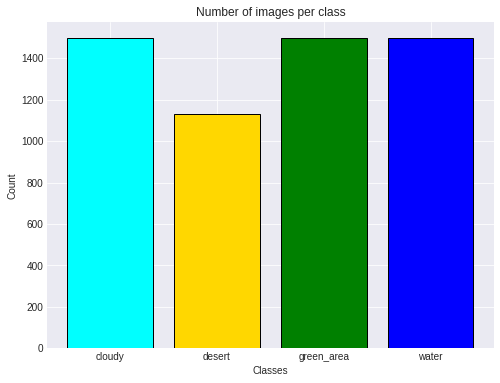

In [8]:
plot_hist(dict_class_count)

In [15]:
def print_images(root_dir):
    '''return count of number of images per class'''
    plt.style.use('seaborn-white')
    images_plt=[]
    classes=[]
    f, axarr = plt.subplots(1,4, figsize=(15,15)) 
    for folder in sorted(os.listdir(root_dir)):
      image_folder = root_dir+ '/'+str(folder) + '/'
      classes.append(str(folder))
      images_plt.append(image.imread(random.choice([image_folder+image_filename for image_filename in sorted(os.listdir(image_folder))])))

    axarr[0].imshow(images_plt[0])
    axarr[0].set_title(classes[0])
    axarr[1].imshow(images_plt[1])
    axarr[1].set_title(classes[1])
    axarr[2].imshow(images_plt[2])
    axarr[2].set_title(classes[2])
    axarr[3].imshow(images_plt[3])
    axarr[3].set_title(classes[3])
    plt.show
    

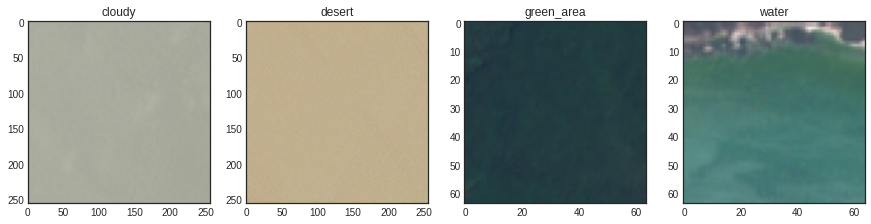

In [16]:
print_images(root_dir)

In [17]:
def load_data(path, test_split, val_split, batch_size, input_size):

    normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                     std=[0.5, 0.5, 0.5])
    
    transform_dict = {'src':  transforms.Compose([transforms.Resize(input_size),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.RandomVerticalFlip(),
                                   transforms.RandomAdjustSharpness(0.2),
                                   transforms.RandomAutocontrast(),
                             transforms.ToTensor(), normalize])}

    data = datasets.ImageFolder(root=path, transform=transform_dict["src"])

    val_size = int(len(data) * val_split)
    test_size = int(len(data) * test_split)
    train_size = len(data)- (val_size + test_size)

    train_dataset, test_dataset, val_dataset = td.random_split(data, [train_size, test_size, val_size])

    
    data_loader_train= td.DataLoader(train_dataset, batch_size=batch_size,
                                    shuffle=True, pin_memory=True, drop_last = False,
                                     num_workers = 0)
    
    data_loader_test = td.DataLoader(test_dataset, batch_size=batch_size,
                                    shuffle=True, pin_memory=True, drop_last = False,
                                     num_workers = 0)
    
    data_loader_val = td.DataLoader(val_dataset, batch_size=batch_size,
                                    shuffle=True, pin_memory=True, drop_last = False,
                                     num_workers = 0)
      
    return data_loader_train, data_loader_test, data_loader_val,data

In [18]:
train_loader, test_loader, valid_loader,data= load_data(root_dir, test_split=0.3, val_split=0.1, batch_size=32, input_size=[64,64])

In [13]:
# checking the train loader dataset information
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Image batch dimensions: torch.Size([32, 3, 64, 64])
Image label dimensions: torch.Size([32])
Class labels of 10 examples: tensor([2, 0, 1, 1, 3, 1, 1, 0, 0, 3])


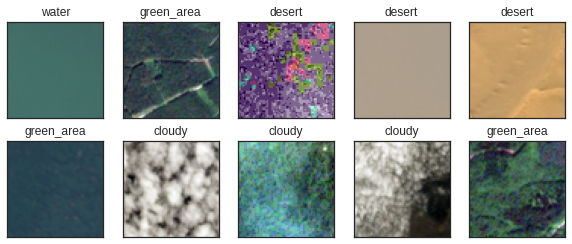

In [18]:
def getList(dict):
  list = []
  for key in dict.keys():
    list.append(key)
  return list

labelsdec = data.class_to_idx 
classes = getList(labelsdec)

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain one batch of training images
data_iter = iter(train_loader)
images, lbls = data_iter.next()
images = images.numpy() # convert images to numpy for display
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(10, 4))
# display 10 images
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    label = lbls[idx]
    ax.set_title(classes[lbls[idx]])
  

In [19]:
label_encoding = data.class_to_idx  
print("label mapping is ", label_encoding)

label mapping is  {'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}


#### Load RESNET50 Model 

In [ ]:
model = models.resnet50(pretrained=False)  # By default, no pre-trained weights are used.

In [21]:
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4) #num_classes = 4

#### Train the Model

In [23]:
def compute_accuracy(model, data_loader, device):

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.float().to(device)

            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)

            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [26]:
def train_model(model, num_epochs, train_loader,
                valid_loader, test_loader, optimizer,
                device, logging_interval=100,
                scheduler=None, threshold = 99,
                scheduler_on='valid_acc'):

    start_time = time.time()
    minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []
    
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(device)
            targets = targets.to(device)

            #forard and back prop
            logits = model(features)
            loss = torch.nn.functional.cross_entropy(logits, targets)
            optimizer.zero_grad()
            loss.backward()
            # update mdoel parameters
            optimizer.step()

            #logging
            minibatch_loss_list.append(loss.item())
            if not batch_idx % logging_interval:
                print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                      f'| Batch {batch_idx:04d}/{len(train_loader):04d} '
                      f'| Loss: {loss:.4f}')

        model.eval()
        with torch.no_grad():  # save memory during inference
            train_acc = compute_accuracy(model, train_loader, device=device)
            valid_acc = compute_accuracy(model, valid_loader, device=device)
            print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                  f'| Train ACC: {train_acc :.2f}% '
                  f'| Validation ACC: {valid_acc :.2f}%')
            train_acc_list.append(train_acc.item())
            valid_acc_list.append(valid_acc.item())

            if valid_acc > threshold:  #early stopping
              #saving the best model
              torch.save(model, './satellite_model_best_acc_resnet')
              break #stopping the training

        elapsed = (time.time() - start_time)/60
        print(f'Time elapsed: {elapsed:.2f} min')

        if scheduler is not None:

            if scheduler_on == 'valid_acc':
                scheduler.step(valid_acc_list[-1])
            elif scheduler_on == 'minibatch_loss':
                scheduler.step(minibatch_loss_list[-1])
            else:
                raise ValueError(f'Invalid `scheduler_on` choice.')
        

    elapsed = (time.time() - start_time)/60
    print(f'Total Training Time: {elapsed:.2f} min')

    test_acc = compute_accuracy(model, test_loader, device=device)
    print(f'Test accuracy {test_acc :.2f}%')

    return minibatch_loss_list, train_acc_list, valid_acc_list

In [27]:
# define the loss function
criterion = nn.CrossEntropyLoss()
#Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 7)

num_epochs = 50

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
print("Device: {}".format(device))

model.to(device)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=num_epochs,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=device,
    scheduler=scheduler,
    threshold = 97,
    scheduler_on='valid_acc')

Device: cuda:0
Epoch: 001/050 | Batch 0000/0106 | Loss: 1.3988
Epoch: 001/050 | Batch 0100/0106 | Loss: 0.8117
Epoch: 001/050 | Train ACC: 68.16% | Validation ACC: 68.21%
Time elapsed: 52.88 min
Epoch: 002/050 | Batch 0000/0106 | Loss: 0.7454


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 002/050 | Batch 0100/0106 | Loss: 0.8285
Epoch: 002/050 | Train ACC: 72.48% | Validation ACC: 74.42%
Time elapsed: 53.30 min
Epoch: 003/050 | Batch 0000/0106 | Loss: 0.6947
Epoch: 003/050 | Batch 0100/0106 | Loss: 0.6680
Epoch: 003/050 | Train ACC: 73.60% | Validation ACC: 76.38%
Time elapsed: 53.76 min
Epoch: 004/050 | Batch 0000/0106 | Loss: 0.5890
Epoch: 004/050 | Batch 0100/0106 | Loss: 0.7094
Epoch: 004/050 | Train ACC: 77.45% | Validation ACC: 80.28%
Time elapsed: 54.18 min
Epoch: 005/050 | Batch 0000/0106 | Loss: 0.5252
Epoch: 005/050 | Batch 0100/0106 | Loss: 1.0750
Epoch: 005/050 | Train ACC: 75.82% | Validation ACC: 73.36%
Time elapsed: 54.61 min
Epoch: 006/050 | Batch 0000/0106 | Loss: 0.3636
Epoch: 006/050 | Batch 0100/0106 | Loss: 0.6197
Epoch: 006/050 | Train ACC: 77.09% | Validation ACC: 80.99%
Time elapsed: 55.03 min
Epoch: 007/050 | Batch 0000/0106 | Loss: 0.6671
Epoch: 007/050 | Batch 0100/0106 | Loss: 0.8363
Epoch: 007/050 | Train ACC: 78.16% | Validation ACC:

In [29]:
def plot_training_loss(minibatch_loss_list, num_epochs, iter_per_epoch, averaging_iterations=100):

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_loss_list)),
             (minibatch_loss_list), label='Minibatch Loss')

    if len(minibatch_loss_list) > 1000:
        ax1.set_ylim([
            0, np.max(minibatch_loss_list[1000:])*1.5
            ])
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    ax1.plot(np.convolve(minibatch_loss_list,
                         np.ones(averaging_iterations,)/averaging_iterations,
                         mode='valid'),
             label='Running Average')
    ax1.legend()

    
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    
    plt.tight_layout()

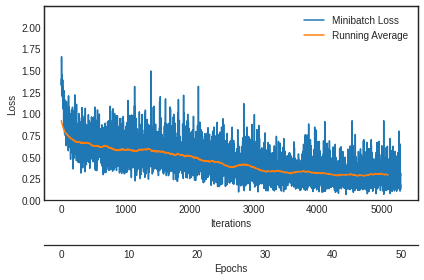

In [30]:
plot_training_loss(minibatch_loss_list, num_epochs, len(train_loader),
                   averaging_iterations=200)
plt.show()

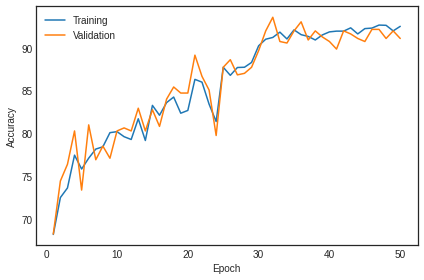

In [31]:
def plot_accuracy(train_acc_list, valid_acc_list):

    num_epochs = len(train_acc_list)
    plt.plot(np.arange(1, num_epochs+1),
             train_acc_list, label='Training')
    plt.plot(np.arange(1, num_epochs+1),
             valid_acc_list, label='Validation')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()

plot_accuracy(train_acc_list, valid_acc_list)
plt.show()

### Predicted labels Visualization

In [32]:
def show_examples(model, data_loader, unnormalizer=None, class_dict=None):
    
        
    for batch_idx, (features, targets) in enumerate(data_loader):

        with torch.no_grad():
            features = features
            targets = targets
            logits = model(features)
            predictions = torch.argmax(logits, dim=1)
        break

    fig, axes = plt.subplots(nrows=3, ncols=5,
                             sharex=True, sharey=True)
    
    if unnormalizer is not None:
        for idx in range(features.shape[0]):
            features[idx] = unnormalizer(features[idx])
    nhwc_img = np.transpose(features, axes=(0, 2, 3, 1))
    
    if nhwc_img.shape[-1] == 1:
        nhw_img = np.squeeze(nhwc_img.numpy(), axis=3)

        for idx, ax in enumerate(axes.ravel()):
            ax.imshow(nhw_img[idx], cmap='binary')
            if class_dict is not None:
                ax.title.set_text(f'P: {class_dict[predictions[idx].item()]}'
                                  f'\nT: {class_dict[targets[idx].item()]}')
            else:
                ax.title.set_text(f'P: {predictions[idx]} | T: {targets[idx]}')
            ax.axison = False

    else:

        for idx, ax in enumerate(axes.ravel()):
            ax.imshow(nhwc_img[idx])
            if class_dict is not None:
                ax.title.set_text(f'P: {class_dict[predictions[idx].item()]}'
                                  f'\nT: {class_dict[targets[idx].item()]}')
            else:
                ax.title.set_text(f'P: {predictions[idx]} | T: {targets[idx]}')
            ax.axison = False
    plt.tight_layout()
    plt.show()

In [33]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

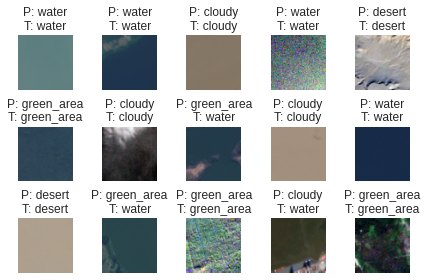

In [34]:
model.cpu()
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

label_encoding = data.class_to_idx  #{'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}
class_dict = {v: k for k, v in label_encoding.items()} #reverse the mapping

show_examples(model=model, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)

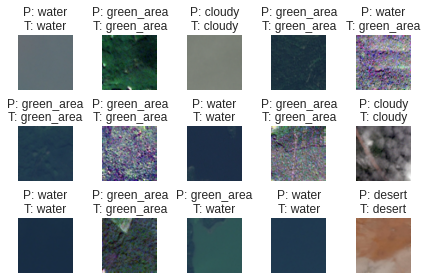

In [35]:
show_examples(model=model, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)

In [36]:
def compute_confusion_matrix(model, data_loader, device):

    all_targets, all_predictions = [], []
    with torch.no_grad():

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets
            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            all_targets.extend(targets.to('cpu'))
            all_predictions.extend(predicted_labels.to('cpu'))

    all_predictions = all_predictions
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
        
    class_labels = np.unique(np.concatenate((all_targets, all_predictions)))
    if class_labels.shape[0] == 1:
        if class_labels[0] != 0:
            class_labels = np.array([0, class_labels[0]])
        else:
            class_labels = np.array([class_labels[0], 1])
    n_labels = class_labels.shape[0]
    lst = []
    z = list(zip(all_targets, all_predictions))
    for combi in product(class_labels, repeat=2):
        lst.append(z.count(combi))
    mat = np.asarray(lst)[:, None].reshape(n_labels, n_labels)
    return mat

def plot_confusion_matrix(conf_mat,
                          hide_spines=False,
                          hide_ticks=False,
                          figsize=None,
                          cmap=None,
                          colorbar=False,
                          show_absolute=True,
                          show_normed=False,
                          class_names=None):

    if not (show_absolute or show_normed):
        raise AssertionError('Both show_absolute and show_normed are False')
    if class_names is not None and len(class_names) != len(conf_mat):
        raise AssertionError('len(class_names) should be equal to number of'
                             'classes in the dataset')

    total_samples = conf_mat.sum(axis=1)[:, np.newaxis]
    normed_conf_mat = conf_mat.astype('float') / total_samples

    fig, ax = plt.subplots(figsize=figsize)
    ax.grid(False)
    if cmap is None:
        cmap = plt.cm.Blues

    if figsize is None:
        figsize = (len(conf_mat)*1.25, len(conf_mat)*1.25)

    if show_normed:
        matshow = ax.matshow(normed_conf_mat, cmap=cmap)
    else:
        matshow = ax.matshow(conf_mat, cmap=cmap)

    if colorbar:
        fig.colorbar(matshow)

    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            cell_text = ""
            if show_absolute:
                cell_text += format(conf_mat[i, j], 'd')
                if show_normed:
                    cell_text += "\n" + '('
                    cell_text += format(normed_conf_mat[i, j], '.2f') + ')'
            else:
                cell_text += format(normed_conf_mat[i, j], '.2f')
            ax.text(x=j,
                    y=i,
                    s=cell_text,
                    va='center',
                    ha='center',
                    color="white" if normed_conf_mat[i, j] > 0.5 else "black")
    
    if class_names is not None:
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=90)
        plt.yticks(tick_marks, class_names)
        
    if hide_spines:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if hide_ticks:
        ax.axes.get_yaxis().set_ticks([])
        ax.axes.get_xaxis().set_ticks([])

    plt.xlabel('predicted label')
    plt.ylabel('true label')
    return fig, ax

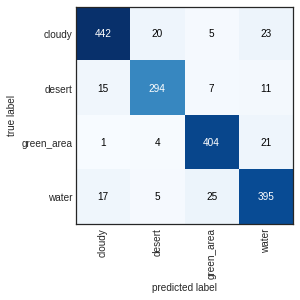

In [37]:
mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

In [38]:
torch.save(model, './model')

In [39]:
from sklearn.metrics import classification_report

target_list = []
predictions_list = []

for batch, (features, targets) in enumerate(test_loader):

  with torch.no_grad():
      # features = features.to(device)
      # targets = targets.float().to(device)
      logits = model(features)
      target_list.extend(targets)
      predictions_list.extend(torch.argmax(logits, dim=1))

print(classification_report(predictions_list, target_list))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       471
           1       0.91      0.91      0.91       325
           2       0.91      0.90      0.90       439
           3       0.88      0.86      0.87       454

    accuracy                           0.90      1689
   macro avg       0.90      0.90      0.90      1689
weighted avg       0.90      0.90      0.90      1689

